In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
datapath = '/content/drive/MyDrive/Colab Notebooks/NLP Projects/transformer/practice_level_two.csv'
df = pd.read_csv(datapath)
df.head()

,Text,Category
0,"মাননীয় প্রধান মন্ত্রী,,কোন আইন আপনার সুশাসনে প...",InASS
1,নৈরাজ্য সৃষ্টি করে দূর্নীতিবাজ তারেক রহমানকে র...,InASS
2,যে দেশের প্রধানমন্ত্রী ভোট চোর সেই দেশে আবার ভ...,InASS
3,হাসিনা কে বাদ দেব আমরা জনগন যতক্ষন পদীপ কুমার ...,InASS
4,ছিছিছি ধিক্কার ধিক্কার ধিক্কার জানাই অবৈধ সরকা...,InASS


<Axes: xlabel='Category'>

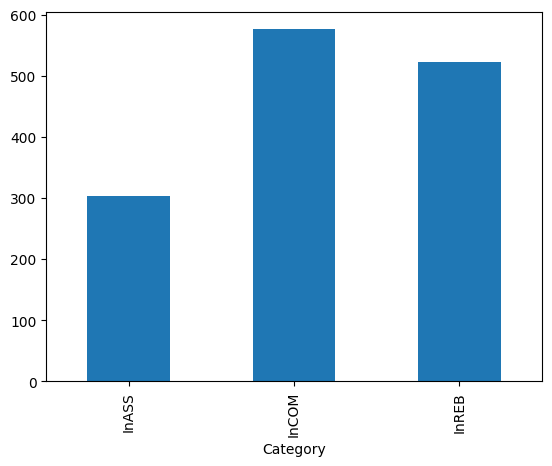

In [ ]:
df.groupby(['Category']).size().plot.bar()

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.0 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")
#from transformers import AutoTokenizer
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
example_text = 'আমি তাকে মেরে ফেলবো'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10,
                       truncation=True, return_tensors="pt")

print(tokenizer)
#print(bert_input['input_ids'])
#print(bert_input['token_type_ids'])
#print(bert_input['attention_mask'])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


BertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


In [ ]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] আমি তাকে ম [SEP]


In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer
#from transformers import AutoTokenizer
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

#model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

#tokenizer = BertTokenizer.from_pretrained("xlm-roberta-base")
labels = {'InASS':0,
          'InCOM':1,
          'InREB':2,
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Category']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1121 140 141


In [ ]:
from torch import nn
from transformers import BertModel
#from transformers import AutoTokenizer
#from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")



from transformers import XLMRobertaModel
import torch.nn as nn

class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = XLMRobertaModel.from_pretrained('xlm-roberta-base')
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(768, 3)  # Replace 'num_classes' with the actual number of classes in your task

    def forward(self, input_id, mask):
        outputs = self.bert(input_ids=input_id, attention_mask=mask)
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        return linear_output


In [ ]:

from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def train(model, train_data, val_data, test_data,learning_rate, epochs):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            model.eval()
            test_labels = []
            test_preds = []
            with torch.no_grad():
                for test_input, test_label in test_dataloader:
                    test_labels += test_label.tolist()
                    test_label = test_label.to(device)
                    mask = test_input['attention_mask'].to(device)
                    input_id = test_input['input_ids'].squeeze(1).to(device)
                    output = model(input_id, mask)
                    preds = output.argmax(dim=1).tolist()
                    test_preds += preds
            precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
            print(f'Test Precision: {precision:.4f} | Test Recall: {recall:.4f} | Test F1 Score: {f1_score:.4f}')


EPOCHS = 7
model = BertClassifier()
LR = 1e-6

train(model, df_train, df_val,df_test ,LR, EPOCHS)



"""
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def train(model, train_data, val_data, test_data, learning_rate, epochs):

    # create dataloaders for training, validation, and test sets
    train, val ,test= Dataset(train_data), Dataset(val_data),Dataset(test_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)



    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # create optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    for epoch_num in range(epochs):

        # training loop
         for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

        # test loop
        model.eval()
        test_labels = []
        test_preds = []
        with torch.no_grad():
            for test_input, test_label in test_dataloader:
                test_labels += test_label.tolist()
                test_label = test_label.to(device)
                mask = test_input['attention_mask'].to(device)
                input_id = test_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)
                preds = output.argmax(dim=1).tolist()
                test_preds += preds
        precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
        print(f'Test Precision: {precision:.4f} | Test Recall: {recall:.4f} | Test F1 Score: {f1_score:.4f}')

        # update model parameters

"""


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 561/561 [02:22<00:00,  3.92it/s]


Epochs: 1 | Train Loss:  0.528                 | Train Accuracy:  0.403                 | Val Loss:  0.484                 | Val Accuracy:  0.493
Test Precision: 0.4424 | Test Recall: 0.5319 | Test F1 Score: 0.4353


100%|██████████| 561/561 [02:25<00:00,  3.85it/s]


Epochs: 2 | Train Loss:  0.373                 | Train Accuracy:  0.712                 | Val Loss:  0.271                 | Val Accuracy:  0.807
Test Precision: 0.7764 | Test Recall: 0.7660 | Test F1 Score: 0.7410


100%|██████████| 561/561 [02:27<00:00,  3.81it/s]


Epochs: 3 | Train Loss:  0.236                 | Train Accuracy:  0.843                 | Val Loss:  0.209                 | Val Accuracy:  0.857
Test Precision: 0.8486 | Test Recall: 0.8511 | Test F1 Score: 0.8487


100%|██████████| 561/561 [02:27<00:00,  3.80it/s]


Epochs: 4 | Train Loss:  0.145                 | Train Accuracy:  0.914                 | Val Loss:  0.184                 | Val Accuracy:  0.843
Test Precision: 0.8491 | Test Recall: 0.8511 | Test F1 Score: 0.8495


100%|██████████| 561/561 [02:27<00:00,  3.81it/s]


Epochs: 5 | Train Loss:  0.098                 | Train Accuracy:  0.946                 | Val Loss:  0.186                 | Val Accuracy:  0.857
Test Precision: 0.8422 | Test Recall: 0.8440 | Test F1 Score: 0.8428


100%|██████████| 561/561 [02:27<00:00,  3.81it/s]


Epochs: 6 | Train Loss:  0.067                 | Train Accuracy:  0.963                 | Val Loss:  0.225                 | Val Accuracy:  0.836
Test Precision: 0.8573 | Test Recall: 0.8582 | Test F1 Score: 0.8560


100%|██████████| 561/561 [02:27<00:00,  3.80it/s]


Epochs: 7 | Train Loss:  0.046                 | Train Accuracy:  0.978                 | Val Loss:  0.184                 | Val Accuracy:  0.864
Test Precision: 0.8443 | Test Recall: 0.8369 | Test F1 Score: 0.8383


'\nfrom torch.optim import Adam\nfrom tqdm import tqdm\nfrom sklearn.metrics import precision_recall_fscore_support\n\ndef train(model, train_data, val_data, test_data, learning_rate, epochs):\n\n    # create dataloaders for training, validation, and test sets\n    train, val ,test= Dataset(train_data), Dataset(val_data),Dataset(test_data)\n    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)\n    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)\n    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)\n\n\n\n    use_cuda = torch.cuda.is_available()\n    device = torch.device("cuda" if use_cuda else "cpu")\n\n    # create optimizer and loss function\n    criterion = nn.CrossEntropyLoss()\n    optimizer = Adam(model.parameters(), lr=learning_rate)\n\n    for epoch_num in range(epochs):\n\n        # training loop\n         for epoch_num in range(epochs):\n\n            total_acc_train = 0\n            total_loss_train = 0\n\n  

In [ ]:
labels = {'InASS': 0, 'InCOM': 1, 'InREB': 2}
inv_labels = {v: k for k, v in labels.items()}

# evaluate on test set and get individual metrics for each class
test = Dataset(df_test)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
test_labels = []
test_preds = []
with torch.no_grad():
    for test_input, test_label in test_dataloader:
        test_labels += test_label.tolist()
        test_label = test_label.to(device)
        mask = test_input['attention_mask'].to(device)
        input_id = test_input['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
        preds = output.argmax(dim=1).tolist()
        test_preds += preds

precision, recall, f1_score, support = precision_recall_fscore_support(test_labels, test_preds, labels=list(labels.values()), average=None)

# print individual metrics for each class
for i, label in inv_labels.items():
    print(f"Metrics for {label}:")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1_score[i]:.4f}")
    print(f"Support: {support[i]}")
#This code first defines the mapping between the class labels and their corresponding indices, and then uses precision_recall_fscore_support with labels=list(labels.values()) and average=None to get the individual metrics for each class. Finally, it prints the metrics for each class using the inv_labels dictionary to map the indices back to their original labels.








Metrics for InASS:
Precision: 0.7812
Recall: 0.8333
F1-score: 0.8065
Support: 30
Metrics for InCOM:
Precision: 0.9273
Recall: 0.8226
F1-score: 0.8718
Support: 62
Metrics for InREB:
Precision: 0.7778
Recall: 0.8571
F1-score: 0.8155
Support: 49


In [ ]:

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

evaluate(model, df_test)

Test Accuracy:  0.837


#Confusion Matrix
